#  🧑‍💻 Fine-tuning generative LLMs 🧑‍💻

📅 _Data Science Summer School 2023, 22.08.2023_

👨‍🏫 By [Moritz Laurer](https://www.linkedin.com/in/moritz-laurer/).
For questions, reach out to: m.laurer@vu.nl


<a target="_blank" href="https://colab.research.google.com/github/MoritzLaurer/summer-school-transformers-2023/blob/main/7_tune_generative_llm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Choosing an LLM

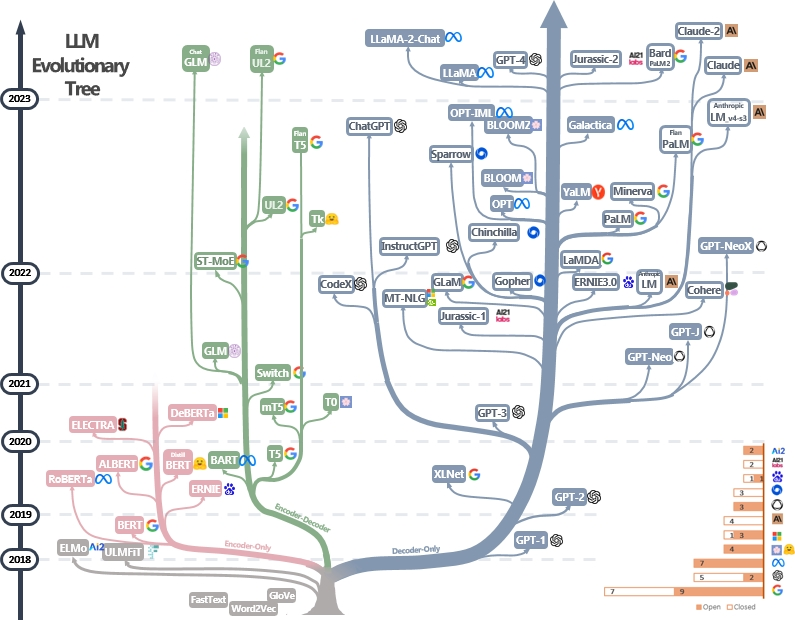

In [ ]:
import requests
from IPython.display import display
from PIL import Image as PILImage
from io import BytesIO

# source: https://github.com/Mooler0410/LLMsPracticalGuide/tree/main
image_url = 'https://github.com/Mooler0410/LLMsPracticalGuide/blob/main/imgs/tree.jpg?raw=true'
response = requests.get(image_url)
img = PILImage.open(BytesIO(response.content))

display(img)

* The [Open LLM Leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)
* Models to start with: `flan-t5` or `llama-2-chat`.

## Activate a GPU runtime

In order to run this notebook on a GPU, click on "Runtime" > "Change runtime type" > select "GPU" in the menue bar in to top left. Training a Transformer is much faster on a GPU. Given Colabs's usage limits for GPUs, it is advisable to first test your non-training code on a CPU and only use the GPU once you know that everything is working.

In [ ]:
# info on the GPU you are using
!nvidia-smi
# info on available ram
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('\n\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Mon Aug 21 17:43:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install relevant packages

In [ ]:
!pip install transformers~=4.31.0 -qqq
!pip install datasets~=2.14.0 -qqq
!pip install accelerate~=0.21.0 -qqq
!pip install bitsandbytes~=0.41.0 -qqq
# ! important note: after running this cell for the first time, click Runtime > Restart runtime
# This makes sure that all the packages are working correctly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.7 MB/s eta 0:00:00


In [ ]:
## Load general packages
# some more specialised packages are loaded in each sub section
import pandas as pd
import numpy as np
from google.colab.data_table import DataTable

In [ ]:
# set random seed for reproducibility
SEED_GLOBAL = 42
np.random.seed(SEED_GLOBAL)

## Download and prepare data

In [ ]:
## Download clean train and test data from github
# data source: https://manifesto-project.wzb.eu/
# codebook with definitions of classes: https://manifesto-project.wzb.eu/down/data/2023a/codebooks/codebook_MPDataset_MPDS2023a.pdf
# more cleaned datasets for testing other tasks: https://github.com/MoritzLaurer/less-annotating-with-bert-nli/tree/master/data_clean

df_train = pd.read_csv("https://raw.githubusercontent.com/MoritzLaurer/less-annotating-with-bert-nli/master/data_clean/df_manifesto_military_train.csv", index_col="idx")
df_test = pd.read_csv("https://raw.githubusercontent.com/MoritzLaurer/less-annotating-with-bert-nli/master/data_clean/df_manifesto_military_test.csv", index_col="idx")
print("Length of training and test sets: ", len(df_train), " (train) ", len(df_test), " (test).")


Length of training and test sets:  3970  (train)  9537  (test).


In [ ]:
# optional: use training data sample size of e.g. 1000 for faster testing
sample_size = 1000
df_train = df_train.sample(n=min(sample_size, len(df_train)), random_state=SEED_GLOBAL).copy(deep=True)
df_test = df_test.sample(n=min(sample_size*4, len(df_test)), random_state=SEED_GLOBAL).copy(deep=True)
print("Length of training and test sets after sampling: ", len(df_train), " (train) ", len(df_test), " (test).")


Length of training and test sets after sampling:  1000  (train)  4000  (test).


In [ ]:
## inspect the data
# label distribution train set
print("Train set label distribution:\n", df_train.label_text.value_counts())
# label distribution test set
print("Test set label distribution:\n", df_test.label_text.value_counts())

# full training data table
DataTable(df_train, num_rows_per_page=5)

Train set label distribution:
 Other                 516
Military: Positive    399
Military: Negative     85
Name: label_text, dtype: int64
Test set label distribution:
 Other                 3646
Military: Positive     248
Military: Negative     106
Name: label_text, dtype: int64


,label,label_text,text_original,label_domain_text,label_subcat_text,text_preceding,text_following,manifesto_id,doc_id,country_name,date,party,cmp_code_hb4,cmp_code,label_subcat_text_simple
idx,,,,,,,,,,,,,,,
71033,0,Military: Negative,a direct role for military forces in the provi...,External Relations,Military: Negative,emergency relief in situations of armed confli...,aid programs should not be used to influence t...,63110_201008,70,Australia,201008,63110,105,105.0,Military
26600,2,Other,and the seriousness of these animal cruelty of...,Welfare and Quality of Life,Environmental Protection,the introduction of a NI Register of Animal Cr...,the PSNI in their efforts to target criminal g...,51903_201706,31,United Kingdom,201706,51903,501,501.0,Environmental Protection
64968,1,Military: Positive,We reject Congressional earmarks that put pers...,External Relations,Military: Positive,We will implement sound management policies to...,"We recognize the need for, and value of, compe...",61620_201211,65,United States,201211,61620,104,104.0,Military
119889,2,Other,"As a partner in Government, the Māori Party ha...",Welfare and Quality of Life,Welfare State Expansion,reviewing the appeal process for ethics commit...,secured $65.3 million for rheumatic fever prev...,64901_201409,141,New Zealand,201409,64901,504,504.0,Welfare State
69067,1,Military: Positive,"Whatever their disagreements, both the Republi...",External Relations,Military: Positive,Both recognized the need to stand with friends...,— and strength meant American military superio...,61620_202011,67,United States,202011,61620,104,104.0,Military
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5284,2,Other,We must make substantial changes in the way we...,Welfare and Quality of Life,Environmental Protection,The healthy future of our environment is one o...,The UK played a leading role in the Kyoto conf...,51320_200106,7,United Kingdom,200106,51320,501,501.0,Environmental Protection
27167,1,Military: Positive,"Armed Forces Personnel, born outside the Unite...",External Relations,Military: Positive,The DUP supports: A new long-term plan for Arm...,The DUP supports: Waiving indefinite leave to ...,51903_201912,32,United Kingdom,201912,51903,104,104.0,Military
101296,2,Other,"Increase support for mothers, before birth and...",Welfare and Quality of Life,Welfare State Expansion,Increase funding for community-based providers...,Establish family health clinics within family ...,64421_200207,120,New Zealand,200207,64421,504,504.0,Welfare State


## Format the data for label generation with instructions

**Formulate instructions, which verbalise the task/class you are interested in.**

For this example, we base our task on the Manifesto Project codebook:  https://manifesto-project.wzb.eu/coding_schemes/mp_v4

In [ ]:
instruction = """
Which of the following categories fits best for the quote above?
A: Military Negative: The quote is negative towards the military, for example against military spending, for disarmament, or against conscription.
B: Military Positive: The quote is positive towards the military, for example for military spending, defense, or military treaty obligations.
C: Other: The quote is not about military or defense.
Only answer one of these options: A, B, or C.
Answer: """

**Prepare the input text**

1.) During the annotation process, annotators are always tasked with annotating a single highlighted (quasi-)sentence. They also see the surrounding sentences for context. We therefore prepare the input text for the model in a similar way: We highlight the target sentence by wrapping it in a string: ` The quote: "{target_text}" - end of the quote.`  We then add the preceding and the following sentence for context. Adding context like this systematically increases performance.

2.) We then append the instructions for the model to each text.


In [ ]:
text_train = df_train.text_preceding.fillna("") + '. The quote: "' + df_train.text_original.fillna("") + '" - end of the quote. ' + df_train.text_following.fillna("")
text_train_instruction = text_train + instruction

text_test = df_test.text_preceding.fillna("") + '. The quote: "' + df_test.text_original.fillna("") + '" - end of the quote. ' + df_test.text_following.fillna("")
text_test_instruction = text_test + instruction

df_train["text_prepared"] = text_train_instruction
df_test["text_prepared"] = text_test_instruction


In [ ]:
label_generation_map = {
    0: "A",  # "Military: Negative"
    1: "B",  # "Military: Positive"
    2: "C",  # "Military: Other"
}

df_train["labels"] = df_train["label"].map(label_generation_map)
df_test["labels"] = df_test["label"].map(label_generation_map)
# ! note that the new column here is called "labels" with an "s" at the end. Some hugging face functions expect the labels column to have this name with an "s".

In [ ]:
# remove unnecessary columns
df_train = df_train[["text_prepared", "labels", "label_text"]]
df_test = df_test[["text_prepared", "labels", "label_text"]]

DataTable(df_train.head())

,text_prepared,labels,label_text
idx,,,
71033,emergency relief in situations of armed confli...,A,Military: Negative
26600,the introduction of a NI Register of Animal Cr...,C,Other
64968,We will implement sound management policies to...,B,Military: Positive
119889,reviewing the appeal process for ethics commit...,C,Other
69067,Both recognized the need to stand with friends...,B,Military: Positive


## Fine-tuning

We use [Hugging Face Transformers](https://huggingface.co/docs/transformers/index) for loading and training our model. They provide great documentation and also a very good [course](https://huggingface.co/course/chapter1/1) on how to use Transformers.

**Choosing a generative model**

There are many generative models available on the Hugging Face Hub (tags ["text generation"](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending) or ["text2text generation"](https://huggingface.co/models?pipeline_tag=text2text-generation&sort=trending)). Text generation models like Llama or Falcon (decoder-only) are good for use-cases that require generating longer, fluent texts, such as chat bots; text2text models like T5 (encoder-decoder) are better for use-cases that require analysing/understanding a text, such as classification or summarization. This notebook therefore uses a version of T5. You can test other models too. The principles are the same across models.

**Loading a generative model**




In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, GenerationConfig
import torch

model_name = "google/flan-t5-base"

device = "cuda" if torch.cuda.is_available() else "cpu"

model_params = {
    #"torch_dtype": torch.bfloat16,  #torch.bfloat16, torch.float16
    #load_in_8bit=True,
    "device_map": "auto",
    "offload_folder": "offload",
    "offload_state_dict": True
}

# see all possible parameters with explanations:
# https://huggingface.co/docs/transformers/main_classes/text_generation
config_params = {
    "max_new_tokens": 2,
    "num_beams": 1,
    #"generation_num_beams": 5,  # https://github.com/huggingface/transformers/blob/68287689f2f0d8b7063c400230b3766987abf18d/src/transformers/training_args_seq2seq.py#L42
    "num_return_sequences": 1,
    "temperature": 0,  # default: 1.0
    "top_k": 1,  # default: 50
    "return_dict_in_generate": True,
    "output_scores": True,
    #"predict_with_generate": False,
    #"include_inputs_for_metrics": True
    "renormalize_logits": "True",
}

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True);
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, **model_params);
model.to(device)

generation_config = GenerationConfig.from_pretrained(model_name, **config_params)
model.generation_config = generation_config



Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at google/flan-t5-base and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Tokenize data**

In [ ]:
# tokenize
import datasets

dataset = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(df_train),
    "test": datasets.Dataset.from_pandas(df_test)
})

max_input_length = 512 - 16
max_target_length = 16

text_col = "text_prepared"
label_col = "labels"

# to deal with fact that labels are also input text
def preprocess_function(examples):
    # tokenize text
    model_inputs = tokenizer(
        examples[text_col], max_length=max_input_length, truncation=True,
    )
    # tokenize labels, since they are also text for generative models
    labels = tokenizer(
        examples[label_col], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

dataset = dataset.map(preprocess_function, batched=True)

# remove unnecessary columns for model training
dataset = dataset.remove_columns(['label_text'])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

**Inspect processed data**

In [ ]:
print("The overall structure of the pre-processed train and test sets:\n")
print(dataset)

print("\n\nAn example for a tokenized input:\n")
print(dataset["train"][0])

The overall structure of the pre-processed train and test sets:

DatasetDict({
    train: Dataset({
        features: ['text_prepared', 'labels', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text_prepared', 'labels', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})


An example for a tokenized input:

{'text_prepared': 'emergency relief in situations of armed conflict should be carried out by civilians and must be clearly distinguished from any military activities.. The quote: "a direct role for military forces in the provision of relief should be restricted to situations involving natural disasters where ambiguity over the military role is unlikely to arise." - end of the quote. aid programs should not be used to influence the democratic preferences of any nation.\nWhich of the following categories fits best for the quote above?\nA: Military Negative: The quote is negative towards the military, for 

### Setting training arguments / hyperparameters

The following cell sets several important hyperparameters. We chose parameters that work well in general to avoid the need for hyperparameter search. Further below, we also provide code for hyperparameter search, if researchers want to try to increase performance by a few percentage points.

In [ ]:
from transformers import Seq2SeqTrainingArguments, Trainer, logging

# Set the directory to write the fine-tuned model and training logs to.
# With google colab, this will create a temporary folder, which will be deleted once you disconnect.
# You can connect to your personal google drive to save models and logs properly.
training_directory = ""

# Hugging Face tipps to increase training speed and decrease out-of-memory (OOM) issues: https://huggingface.co/transformers/performance.html?
# Overview of all training arguments: https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments
train_args = Seq2SeqTrainingArguments(
    output_dir=f'./results/{training_directory}',
    logging_dir=f'./logs/{training_directory}',
    learning_rate=5e-4,
    per_device_train_batch_size=16,  # if you get an out-of-memory error, reduce this value to 8 or 4 and restart the runtime. Higher values increase training speed, but also increase memory requirements. Ideal values here are always a multiple of 8.
    per_device_eval_batch_size=64,  # if you get an out-of-memory error, reduce this value, e.g. to 40 and restart the runtime
    #gradient_accumulation_steps=4, # Can be used in case of memory problems to reduce effective batch size. accumulates gradients over X steps, only then backward/update. decreases memory usage, but also slightly speed. (!adapt/halve batch size accordingly)
    #gradient_checkpointing=True,  # reduces memory requirements, but makes training a bit slower
    num_train_epochs=4,  # this can be increased, but higher values increase training time. Good values for NLI are between 3 and 20.
    warmup_ratio=0.25,  # a good normal default value is 0.06 for normal BERT-base models, but since we want to reuse prior NLI knowledge and avoid catastrophic forgetting, we set the value higher
    weight_decay=0.1,
    lr_scheduler_type="linear",
    seed=SEED_GLOBAL,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    predict_with_generate=True,
    #fp16=fp16_bool,  # Can speed up training and reduce memory consumption, but only makes sense at batch-size > 8. loads two copies of model weights, which creates overhead. https://huggingface.co/transformers/performance.html?#fp16
    #fp16_full_eval=fp16_bool,
    evaluation_strategy="epoch", # options: "no"/"steps"/"epoch"
    save_strategy = "epoch",  # options: "no"/"steps"/"epoch"
    #eval_steps=10_000,  # evaluate after n steps if evaluation_strategy!='steps'. defaults to logging_steps
    #save_steps=10_000,              # Number of updates steps before two checkpoint saves.
    #save_total_limit=10,             # If a value is passed, will limit the total amount of checkpoints. Deletes the older checkpoints in output_dir
    #logging_strategy="steps",
    report_to="all",  # "all"  # logging
    #push_to_hub=False,
    #push_to_hub_model_id=f"{model_name}-finetuned-{task}",
)


### Custom function for classification metrics for generative LLMs


In [ ]:
# helper function to clean memory and reduce risk of out-of-memory error
import gc
def clean_memory():
  #del(model)
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
  gc.collect()

clean_memory()

In [ ]:
import numpy as np
import warnings
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, accuracy_score


def compute_metrics_generative(eval_pred):
    predictions, labels = eval_pred
    # decode and lower case prediction
    labels_pred = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels_pred = [label.lower() for label in labels_pred]
    # decode and lower gold label
    # Replace -100 in the labels as we can't decode them
    labels_gold = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels_gold = tokenizer.batch_decode(labels_gold, skip_special_tokens=True)
    labels_gold = [label.lower() for label in labels_gold]

    warnings.filterwarnings('ignore')
    ## metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels_gold, labels_pred, average='macro', zero_division=0)  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(labels_gold, labels_pred, average='micro', zero_division=0)  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
    acc_balanced = balanced_accuracy_score(labels_gold, labels_pred)
    acc_not_balanced = accuracy_score(labels_gold, labels_pred)

    metrics = {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'accuracy_balanced': acc_balanced,
        #'accuracy_not_b': acc_not_balanced,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        #'label_gold_raw': labels_gold,
        #'label_predicted_raw': labels_pred
    }
    # rounding
    metrics = {key : round(metrics[key], 3) if key not in ["label_gold_raw", "label_predicted_raw"] else {key: metrics[key]} for key in metrics}

    #print("  Aggregate metrics: ", {key: metrics[key] for key in metrics if key not in ["label_gold_raw", "label_predicted_raw"]} )  # print metrics but without label lists
    #print("Detailed metrics: ", classification_report(labels, preds_max, labels=np.sort(pd.factorize(label_text_alphabetical, sort=True)[0]), target_names=label_text_alphabetical, sample_weight=None, digits=2, output_dict=True, zero_division='warn'), "\n")

    # clean memory
    clean_memory()

    warnings.filterwarnings('default')
    return metrics


### Fine-tuning and evaluation

In [ ]:
from transformers import DataCollatorForSeq2Seq
# data collators help feed the data into the model in batches during training
# text2text modesl require a specific data collator
# docs: https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    train_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_generative,
    #ignore_keys=["label_gold_raw", "label_prediction_raw"]  # https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/trainer#transformers.Trainer.evaluate
)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Balanced,Precision Macro,Recall Macro,Precision Micro,Recall Micro
1,No log,0.110909,0.651000,0.944000,0.669000,0.789000,0.669000,0.944000,0.944000
2,No log,0.204940,0.621000,0.913000,0.702000,0.722000,0.702000,0.913000,0.913000
3,No log,0.151705,0.719000,0.938000,0.779000,0.695000,0.779000,0.938000,0.938000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


  Aggregate metrics:  {'f1_macro': 0.651, 'f1_micro': 0.944, 'accuracy_balanced': 0.669, 'precision_macro': 0.789, 'recall_macro': 0.669, 'precision_micro': 0.944, 'recall_micro': 0.944}
  Aggregate metrics:  {'f1_macro': 0.621, 'f1_micro': 0.913, 'accuracy_balanced': 0.702, 'precision_macro': 0.722, 'recall_macro': 0.702, 'precision_micro': 0.913, 'recall_micro': 0.913}
  Aggregate metrics:  {'f1_macro': 0.719, 'f1_micro': 0.938, 'accuracy_balanced': 0.779, 'precision_macro': 0.695, 'recall_macro': 0.779, 'precision_micro': 0.938, 'recall_micro': 0.938}


TrainOutput(global_step=189, training_loss=0.06927471059970755, metrics={'train_runtime': 227.9077, 'train_samples_per_second': 13.163, 'train_steps_per_second': 0.829, 'total_flos': 923181303103488.0, 'train_loss': 0.06927471059970755, 'epoch': 3.0})

In [ ]:
## Evaluate the fine-tuned model on the held-out test set
#results = trainer.evaluate()
#print(results)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Any questions while the training is running?**

## Inference with your fine-tuned model or any other LLM (0-shot)

The code above showed how to fine-tune a custom generative LLM. This section shows how to use this fine-tuned model (or an existing generative LLM) to predict classes on unseen texts. There are several ways of implementing this. We show a simple implementation with the Hugging Face pipline.

In [ ]:
instruction = """
Which of the following categories fits best for the quote above:
A: Military Negative: The quote is negative towards the military, for example against military spending, for disarmament, or against conscription.
B: Military Positive: The quote is positive towards the military, for example for military spending, defense, or military treaty obligations.
C: Other: The quote is not about military or defense.
Only answer one of these options: A, B, or C.
Answer: """

In [ ]:
from transformers import pipeline
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"  # use GPU (cuda) if available, otherwise use CPU

# documentation: https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.ZeroShotClassificationPipeline
pipe_classifier = pipeline(
    "text2text-generation",
    model=model,  # if you have trained a model above, load_best_model_at_end in the training arguments has automatically replaced model with the fine-tuned model
    # or load an existing pre-trained model from the Hugging Face hub
    #model=model_name,
    tokenizer=tokenizer,
    framework="pt",
    device=device,
)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:58: DeprecationWarning: distutils Version classes are deprecated. Use

We now apply the pipeline to unseen texts. We re-use the df_test data-frame here for simplicity, but it could be any other dataset. It only needs a text column. If you want to better understand the arguments in the pipeline below, we recommend reading the [documentation here](https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.Text2TextGenerationPipeline).

In [ ]:
# create a dummy dataframe for illustration
df_inference = df_test[["text_prepared", "label_text", "labels"]].sample(n=1000, random_state=42).copy(deep=True)
text_lst = df_inference["text_prepared"].tolist()

# use the pipeline with your chosen model for inference (prediction)
pipe_output = pipe_classifier(
    text_lst,  # input any list of texts here
    batch_size=32  # reduce this number to 8 or 16 if you get an out-of-memory error
)
print(pipe_output)

# extract the predictions from pipe_output
label_pred = [dic["generated_text"] for dic in pipe_output]

# add inference data to your original dataframe
df_inference["labels_pred"] = label_pred


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'B'}, {'generated_text': 'B'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'B'}, {'generated_text': 'C'}, {'generated_text': 'A'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'B'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'}, {'generated_text': 'C'},

In [ ]:
DataTable(df_inference)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text_prepared,label_text,labels,labels_pred
idx,,,,
103403,• To continue to maintain inflation in the ran...,Other,C,C
13031,End the 1 % cap on pay rises in the public sec...,Other,C,C
27347,These savings include: Reducing the size of th...,Other,C,C
104422,This will allow victims to say more in their V...,Other,C,C
62765,"Throughout the Cold War, our international bro...",Other,C,B
...,...,...,...,...
40325,"Legislate to regulate the charity sector,. The...",Other,C,C
47579,Support the further development of farmers’ ma...,Other,C,C
73225,Small businesses will benefit from the instant...,Other,C,C


In [ ]:
# inspect mistakes
DataTable(df_inference[df_inference.labels != df_inference.labels_pred])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text_prepared,label_text,labels,labels_pred
idx,,,,
62765,"Throughout the Cold War, our international bro...",Other,C,B
58500,Democrats will save lives by using every avail...,Other,C,B
39531,Civilian Support – In order to ensure that pro...,Other,C,B
73486,"Through the development assistance program, we...",Other,C,B
60366,and claimed more than half a million lives.. T...,Military: Negative,A,B
60303,and ensure they are better prepared to advance...,Military: Negative,A,B
56579,"After taking office, President Obama removed o...",Military: Negative,A,B
56588,As the Bush administration shifted its focus t...,Military: Negative,A,B
60445,Democrats will not abide exploitation of our v...,Other,C,B


## Save and load your fine-tuned model

This segment provides code for saving the model to your hard-disk or for uploading it to the Hugging Face hub.

In [ ]:
upload_model = False
assert upload_model, "Stopping the code here to avoid accidentally running the code below when running the full notebook."

In [ ]:
## first you need to connect to your google drive with your google account
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=False)
#drive.flush_and_unmount()

# insert the path where you want to save the model
os.chdir("/content/drive/My Drive/")
print(os.getcwd())


In [ ]:
### save best model to disk
directory_save_model = f"{training_directory}/"
model_name_custom = f"{model_name.split('/')[-1]}-custom"
mode_custom_path = directory_save_model + model_name_custom

# save the model to google drive
trainer.save_model(output_dir=mode_custom_path)

In [ ]:
### Push to Hugging Face hub
# install necessary dependencies
# you need to create an account on https://huggingface.co/ for this
!git config --global credential.helper store
!sudo apt-get install git-lfs
!huggingface-cli login

In [ ]:
# load your models and tokenizer saved before from disk
model = AutoModelForSeq2SeqLM.from_pretrained(mode_custom_path)
tokenizer = AutoTokenizer.from_pretrained(mode_custom_path, use_fast=True, model_max_length=512)

In [ ]:
# https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.push_to_hub
repo_id = '<your-user-name>/<your-model-name>'  # e.g. "JaneJones/DeBERTa-v3-nli-custom". note that the repo name is case-sensitive
model.push_to_hub(repo_id=repo_id, use_temp_dir=True, private=True, use_auth_token="<your-huggingface-token>")
tokenizer.push_to_hub(repo_id=repo_id, use_temp_dir=True, private=True, use_auth_token="<your-huggingface-token>")


---

---

## Exercise  +  Q&A

**Exercise:** (5-10 min)

* Look at the `instruction` above and try to think of different ways of formulating the instructions. Rewrite the instruction in the code and then rerun the code with `Runtime` > `Restart and run all`. Make sure you have selected a GPU (`Runtime` >  `Change runtime type`). Careful: you might need to adjust `label_generation_map` if you change the verbalised labels from A/B/C to something else.
* Post some of your instructions in the chat to help inspire the others.
* **Re-read the notebook and post any questions in the chat.**

